In [1]:
from tqdm.notebook import tqdm
import numpy as np
import math
import pandas as pd
from rank_bm25 import *
import sqlite3
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import ndcg_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## BM25 BASELINE

In [2]:
'''Create FBI Dataframe'''
fbi_df = pd.read_csv('missing_person.csv')
office_list = [] 
for word in fbi_df['fieldOffices']:
    nw = str(word).replace("['","").replace("']","").replace("'", "")
    if nw == 'nan':
        nw = 'NaN'
    office_list.append(nw)
fbi_df['fieldOffices'] = office_list
fbi_df = fbi_df.reset_index()
fbi_df.rename(columns={'index':'doc_id'}, inplace=True)
#starting doc_ids at 1 instead of 0
fbi_df.doc_id = fbi_df.doc_id + 1

'''Create corpus dataframe with race and details as content'''
corpus = pd.DataFrame()
cols = ['race','details']
corpus['id'] = fbi_df['doc_id']
corpus['contents'] = fbi_df[cols].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)
corpus


'''Query Dataframe'''
queries = pd.read_csv('queries2.csv')
queries = queries.rename(columns={"doc_id": "id", "contents": "contents"})

In [3]:
'''Tokenize corpus contents and remove stopwords and punctuation'''
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords

punctuation = "!@#$%^&*()_+<>?:.,;”’``''"

stop_words = set(stopwords.words('english'))

words = []
for line in corpus['contents']:
    word = word_tokenize(line.lower())
    filtered = [w for w in word if not w.lower() in stop_words]
    punct = [w for w in filtered if not w.lower() in punctuation]
    words.append(punct)

In [4]:
'''Get top 10 BM25 scores for each query and corpus'''
results = []
for q, j in tqdm(zip(queries['contents'], queries['id'])):
    hold = []
    bm25 = BM25Okapi(words)
    doc_scores = bm25.get_scores(q.split()).tolist()
    for d, x in zip(corpus['id'], doc_scores):
        l = [j, d, x]
        hold.append(l)
    f = sorted(hold, key = lambda x: x[2], reverse=True)[:10]
    results.append(f)

0it [00:00, ?it/s]

In [5]:
'''Create a better list of lists to convert to df'''
final = []
for x in results:
    for y in x:
        final.append(y)
relevancy_df = pd.DataFrame(final, columns = ['QueryId', 'DocId', 'BM25Score'])
relevancy_df

,QueryId,DocId,BM25Score
0,0,152,4.103316
1,0,14,3.560423
2,0,30,2.342301
3,0,31,2.342301
4,0,7,2.262534
...,...,...,...
195,19,136,4.324714
196,19,24,3.844553
197,19,57,3.480160
198,19,162,3.444675


In [6]:
'''Convert df to csv and manually add in relevancy scores'''
relevancy_df.to_csv(r'relevancy_scores.csv',index=False)

### CALCULATE PRECISION

In [9]:
relevance = pd.read_csv('relevancy_scores_complete.csv')
relevance['topk'] = 5
relevance

,QueryId,DocId,BM25Score,RelevancyScore,topk
0,0,152,4.103316,1,5
1,0,14,3.560423,4,5
2,0,30,2.342301,2,5
3,0,31,2.342301,3,5
4,0,7,2.262534,1,5
...,...,...,...,...,...
195,19,136,4.324714,5,5
196,19,24,3.844553,3,5
197,19,57,3.480160,3,5
198,19,162,3.444675,3,5


In [13]:
relevance['RelevancyScore'].value_counts()

5    51
1    48
3    36
2    33
4    32
Name: RelevancyScore, dtype: int64

In [10]:
r = relevance['RelevancyScore'].tolist()
top = relevance['topk'].tolist()

In [11]:
from sklearn.metrics import ndcg_score
baseline_ndcg = ndcg_score([r], [top])
baseline_ndcg

0.8899145481636758

## BM25 WITH ADDITIONAL INFO

In [14]:
'''Create FBI Dataframe'''
fbi_df = pd.read_csv('missing_person.csv')
office_list = [] 
for word in fbi_df['fieldOffices']:
    nw = str(word).replace("['","").replace("']","").replace("'", "")
    if nw == 'nan':
        nw = 'NaN'
    office_list.append(nw)
fbi_df['fieldOffices'] = office_list
fbi_df = fbi_df.reset_index()
fbi_df.rename(columns={'index':'doc_id'}, inplace=True)
#starting doc_ids at 1 instead of 0
fbi_df.doc_id = fbi_df.doc_id + 1

'''Create corpus dataframe with race and details as content'''
corpus = pd.DataFrame()
cols = ['race', 'hair', 'eyeColor', 'details']
fbi_df['hair'] = fbi_df['hair'] + ' hair'
fbi_df['eyeColor'] = fbi_df['eyeColor'] + ' eye'
corpus['id'] = fbi_df['doc_id']
corpus['contents'] = fbi_df[cols].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)
corpus

'''Query Dataframe'''
queries = pd.read_csv('queries2.csv')
queries = queries.rename(columns={"doc_id": "id", "contents": "contents"})

In [15]:
'''Tokenize corpus contents and remove stopwords and punctuation'''
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords

punctuation = "!@#$%^&*()_+<>?:.,;”’``''"

stop_words = set(stopwords.words('english'))

words = []
for line in corpus['contents']:
    word = word_tokenize(line.lower())
    filtered = [w for w in word if not w.lower() in stop_words]
    punct = [w for w in filtered if not w.lower() in punctuation]
    words.append(punct)

In [16]:
'''Get top 10 BM25 scores for each query and corpus'''
results3 = []
for q, j in tqdm(zip(queries['contents'], queries['id'])):
    hold = []
    bm25 = BM25Okapi(words)
    doc_scores = bm25.get_scores(q.split()).tolist()
    for d, x in zip(corpus['id'], doc_scores):
        l = [j, d, x]
        hold.append(l)
    f = sorted(hold, key = lambda x: x[2], reverse=True)[:10]
    results3.append(f)

0it [00:00, ?it/s]

In [17]:
'''Create a better list of lists to convert to df'''
final3 = []
for x in results3:
    for y in x:
        final3.append(y)
bm25update_relevancy_df = pd.DataFrame(final3, columns = ['QueryId', 'DocId', 'BM25Score'])
bm25update_relevancy_df

,QueryId,DocId,BM25Score
0,0,152,4.113657
1,0,14,3.673290
2,0,30,2.405631
3,0,31,2.389863
4,0,7,2.358938
...,...,...,...
195,19,136,4.453567
196,19,24,3.769301
197,19,57,3.469251
198,19,1,3.339206


In [21]:
'''Convert df to csv and manually add in relevancy scores'''
bm25update_relevancy_df.to_csv(r'bm25update_relevancy_scores.csv',index=False)

### CALCULATE NDCG

In [22]:
bm25_relevance = pd.read_csv('bm25update_relevancy_scores_complete.csv')
bm25_relevance['topk'] = 5
bm25_relevance

,QueryId,DocId,BM25Score,Relevancy,topk
0,0,152,4.113657,1,5
1,0,14,3.673290,4,5
2,0,30,2.405631,2,5
3,0,31,2.389863,3,5
4,0,7,2.358938,1,5
...,...,...,...,...,...
195,19,136,4.453567,5,5
196,19,24,3.769301,3,5
197,19,57,3.469251,3,5
198,19,1,3.339206,1,5


In [64]:
bm25_relevance.sample(10)

,QueryId,DocId,BM25Score,Relevancy,topk
110,11,117,4.587425,5,5
157,15,160,3.778611,1,5
90,9,14,4.950334,4,5
108,10,30,1.147498,2,5
69,6,126,2.539461,2,5
18,1,137,0.754730,3,5
189,18,64,2.577325,3,5
72,7,158,3.569433,5,5
138,13,129,2.825436,1,5
101,10,129,1.356203,5,5


In [37]:
f = bm25_relevance['Relevancy'].value_counts()

In [23]:
r3 = bm25_relevance['Relevancy'].tolist()
top3 = bm25_relevance['topk'].tolist()

In [24]:
bm25_baseline_ndcg = ndcg_score([r3], [top3])
bm25_baseline_ndcg

0.8988189861687521

## BM25L WITH ADDITIONAL INFO

In [30]:
'''Create FBI Dataframe'''
fbi_df = pd.read_csv('missing_person.csv')
office_list = [] 
for word in fbi_df['fieldOffices']:
    nw = str(word).replace("['","").replace("']","").replace("'", "")
    if nw == 'nan':
        nw = 'NaN'
    office_list.append(nw)
fbi_df['fieldOffices'] = office_list
fbi_df = fbi_df.reset_index()
fbi_df.rename(columns={'index':'doc_id'}, inplace=True)
#starting doc_ids at 1 instead of 0
fbi_df.doc_id = fbi_df.doc_id + 1

'''Create corpus dataframe with race and details as content'''
corpus = pd.DataFrame()
cols = ['race', 'hair', 'eyeColor', 'details']
fbi_df['hair'] = fbi_df['hair'] + ' hair'
fbi_df['eyeColor'] = fbi_df['eyeColor'] + ' eye'
corpus['id'] = fbi_df['doc_id']
corpus['contents'] = fbi_df[cols].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)
corpus

'''Query Dataframe'''
queries = pd.read_csv('queries2.csv')
queries = queries.rename(columns={"doc_id": "id", "contents": "contents"})

In [31]:
'''Tokenize corpus contents and remove stopwords and punctuation'''
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords

punctuation = "!@#$%^&*()_+<>?:.,;”’``''"

stop_words = set(stopwords.words('english'))

words = []
for line in corpus['contents']:
    word = word_tokenize(line.lower())
    filtered = [w for w in word if not w.lower() in stop_words]
    punct = [w for w in filtered if not w.lower() in punctuation]
    words.append(punct)

In [32]:
'''Get top 10 BM25 scores for each query and corpus'''
results2 = []
for q, j in tqdm(zip(queries['contents'], queries['id'])):
    hold = []
    bm25L = BM25L(words)
    doc_scores = bm25L.get_scores(q.split()).tolist()
    for d, x in zip(corpus['id'], doc_scores):
        l = [j, d, x]
        hold.append(l)
    f = sorted(hold, key = lambda x: x[2], reverse=True)[:10]
    results2.append(f)

0it [00:00, ?it/s]

In [33]:
'''Create a better list of lists to convert to df'''
final2 = []
for x in results2:
    for y in x:
        final2.append(y)
new_relevancy_df = pd.DataFrame(final2, columns = ['QueryId', 'DocId', 'BM25LScore'])
new_relevancy_df

,QueryId,DocId,BM25LScore
0,0,14,8.690154
1,0,152,5.512457
2,0,30,3.456129
3,0,31,3.445566
4,0,7,3.424885
...,...,...,...
195,19,59,4.555494
196,19,57,2.293559
197,19,1,2.229725
198,19,24,1.995790


In [46]:
new_relevancy_df[60:70]

,QueryId,DocId,BM25Score
60,6,168,8.577664
61,6,125,3.779036
62,6,45,3.559755
63,6,72,3.532272
64,6,129,3.487066
65,6,75,3.395019
66,6,52,3.327765
67,6,126,3.280630
68,6,44,3.271736
69,6,140,3.211756


In [47]:
'''Convert df to csv and manually add in relevancy scores'''
new_relevancy_df.to_csv(r'relevancy_scores_bm25L.csv',index=False)

### CALCULATE NDCG

In [34]:
l_relevance = pd.read_csv('relevancy_scores_bm25L_complete.csv')
l_relevance['topk'] = 5
l_relevance

,QueryId,DocId,BM25LScore,Relevancy,topk
0,0,14,8.690154,5,5
1,0,152,5.512457,5,5
2,0,30,3.456129,5,5
3,0,31,3.445566,5,5
4,0,7,3.424885,3,5
...,...,...,...,...,...
195,19,59,4.555494,5,5
196,19,57,2.293559,4,5
197,19,1,2.229725,2,5
198,19,24,1.995790,2,5


In [36]:
t = l_relevance['Relevancy'].value_counts()

In [53]:
r2 = l_relevance['Relevancy'].tolist()
top2 = l_relevance['topk'].tolist()

In [54]:
bm25l_baseline_ndcg = ndcg_score([r2], [top2])
bm25l_baseline_ndcg

0.9162523158594212

## GRAPHS

In [55]:
dist = pd.DataFrame()
dist['bm25'] = f
dist['bm25L'] = t
dist = dist.reset_index().rename(columns={'index':'relevance'}).sort_values(by='relevance')

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

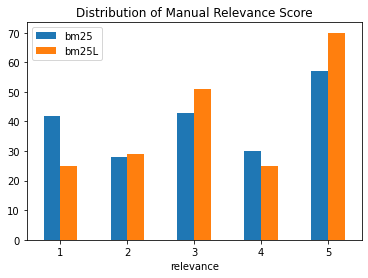

In [63]:
dist.plot(x="relevance", y=["bm25", "bm25L"], kind="bar")
plt.xticks(rotation=0)
plt.title('Distribution of Manual Relevance Score')
plt.show()